## Introdução

Neste notebook, o objetivo foi aplicar a técnica de **Clustering** utilizando o algoritmo **K-Means** para segmentar as casas com base nas suas características, como localização, número de quartos, idade das casas, entre outras variáveis.

O processo de clustering foi dividido nas seguintes etapas:

1. **Preparação dos dados**: Utilizamos as mesmas variáveis que em modelos supervisionados, garantindo que os dados estivessem prontos para o agrupamento.

2. **Determinação do número de clusters (K)**: Utilizamos métodos para determinar o número ideal de clusters para segmentar as casas.

3. **Aplicação do K-Means**: O modelo K-Means foi aplicado para agrupar as casas em clusters, baseando-se nas características fornecidas.

4. **Análise dos resultados**: Após a aplicação do K-Means, os clusters foram analisados para entender as características dos diferentes grupos, como a média dos preços das casas e outros atributos.

A técnica de K-Means permite identificar padrões que podem ser úteis para segmentar o mercado imobiliário, oferecendo uma visão mais detalhada dos diferentes tipos de casas com base em suas características.


In [62]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [92]:
# Carrega os ficheiros
from google.colab import files

# Faz o upload do ficheiro de dados de habitação da Califórnia
uploaded = files.upload()

for fn in uploaded.keys():
    print('O utilizador carregou o ficheiro "{name}" com tamanho {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving housing_sl.csv to housing_sl.csv
O utilizador carregou o ficheiro "housing_sl.csv" com tamanho 1968649 bytes


### Critérios de Seleção dos Dados

As variáveis selecionadas para o modelo incluem:

- `total_rooms`: Total de quartos.
- `total_bedrooms`: Total de quartos de dormir.
- `median_income`: Renda média da localidade.
- `Proximity_level`: Proximidade ao oceano (transformada em variáveis binárias por meio de one-hot encoding).

In [93]:
# 0. Lê o ficheiro
cali_file = pd.read_csv('housing_sl.csv')
housing_df = pd.DataFrame(cali_file)

housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,house_value_range,Proximity_Level_1O,Proximity_Level_B,Proximity_Level_IN,Proximity_Level_IS,Proximity_Level_NO
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,350000,False,True,False,False,False
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,350000,False,True,False,False,False
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,350000,False,True,False,False,False
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,350000,False,True,False,False,False
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,350000,False,True,False,False,False


Primeiramente, os dados foram carregados a partir do dataset de casas, com a seleção das variáveis relevantes como median_income, total_rooms, households, e outras características associadas às casas.

In [94]:
# 1. Seleciona as colunas relevantes: Features e Classes
# Features são as variáveis numéricas (primeiras 10 colunas)
housing_feature_names = housing_df.columns.values.tolist()[:10]

# Classes são as variáveis categóricas já codificadas (restante das colunas)
proximity_columns = housing_df.columns.values.tolist()[10:]

# Mostrar as features e as classes
print('Features:', housing_feature_names, '   Classes:', proximity_columns)


Features: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'house_value_range']    Classes: ['Proximity_Level_1O', 'Proximity_Level_B', 'Proximity_Level_IN', 'Proximity_Level_IS', 'Proximity_Level_NO']


### Preparação dos Dados

Os dados foram previamente limpos, com:
- Remoção de outliers,
- Substituição de valores nulos,
- Aplicação de one-hot encoding para variáveis categóricas como `ocean_proximity`.

### Substituição dos Intervalos de Preço por Valores Numéricos Médios

Primeiro, foi feito o agrupamento dos preços das casas (`median_house_value`) em intervalos. Esses intervalos foram mapeados para valores médios para facilitar a previsão.

```python
house_value_mapping = {
    '0-15000': 7500,
    '15000-30000': 22500,
    '30000-50000': 40000,
    '50000-100000': 75000,
    '100000-200000': 150000,
    '200000-500000': 350000
}
cali_df['house_value_range'] = cali_df['house_value_range'].map(house_value_mapping)
```
Após essa transformação, a variável `house_value_range` tornou-se numérica, representando o intervalo médio do preço das casas.

**Padronização dos Dados**
   - A padronização foi aplicada nas variáveis selecionadas usando o **StandardScaler**. Isso foi feito para garantir que todas as variáveis tivessem a mesma escala, o que é importante para o algoritmo **K-Means**, que é sensível à escala dos dados.
   
   - O método **StandardScaler** transforma os dados para uma distribuição com média 0 e desvio padrão 1, permitindo que o modelo funcione de forma mais eficiente.

## Clustering COM Proximity_Level attribute

In [95]:
# 2. Padroniza todas as colunas selecionadas (Features + Classes)
# Combina todas as features e classes para o clustering
all_columns = housing_feature_names + proximity_columns
scaler = StandardScaler()
housing_scaled = scaler.fit_transform(housing_df[all_columns])  # Padroniza os dados

# Converte para DataFrame para fácil visualização
housing_scaled_df = pd.DataFrame(housing_scaled, columns=all_columns)
print("\nDados Padronizados (primeiras linhas):")
housing_scaled_df.head()


Dados Padronizados (primeiras linhas):


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,house_value_range,Proximity_Level_1O,Proximity_Level_B,Proximity_Level_IN,Proximity_Level_IS,Proximity_Level_NO
0,-1.326470,1.050390,0.979997,-0.813014,-0.977891,-0.977099,-0.983019,2.392454,2.161934,1.247412,-0.889942,2.830519,-0.683701,-0.015598,-0.383617
1,-1.321481,1.041032,-0.609175,2.112974,1.386595,0.877986,1.705235,2.379730,1.337936,1.247412,-0.889942,2.830519,-0.683701,-0.015598,-0.383617
2,-1.331459,1.036353,1.854042,-0.536836,-0.830262,-0.821840,-0.847544,1.821570,1.281893,1.247412,-0.889942,2.830519,-0.683701,-0.015598,-0.383617
3,-1.336448,1.036353,1.854042,-0.627640,-0.721355,-0.766517,-0.735976,0.958508,1.187322,1.247412,-0.889942,2.830519,-0.683701,-0.015598,-0.383617
4,-1.336448,1.036353,1.854042,-0.461557,-0.612449,-0.760271,-0.629721,-0.002178,1.195203,1.247412,-0.889942,2.830519,-0.683701,-0.015598,-0.383617


### K hyperparameter tuning

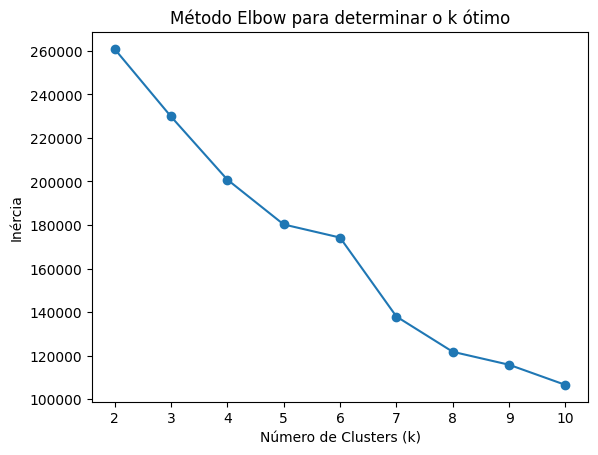

In [96]:
# 3. Determina o número ótimo de clusters com o Método Elbow e Silhouette Score
inertia = []  # Para guardar os valores de inércia
silhouette_scores = []  # Para guardar os valores de Silhouette
k_values = range(2, 11)  # Testa valores de k de 2 a 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=1234)
    kmeans.fit(housing_scaled_df)  # Aplica o K-Means nos dados padronizados
    inertia.append(kmeans.inertia_)  # Guarda a inércia
    silhouette_scores.append(metrics.silhouette_score(housing_scaled_df, kmeans.labels_))  # Calcula Silhouette

# Gera o gráfico do Método Elbow
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método Elbow para determinar o k ótimo')
plt.show()

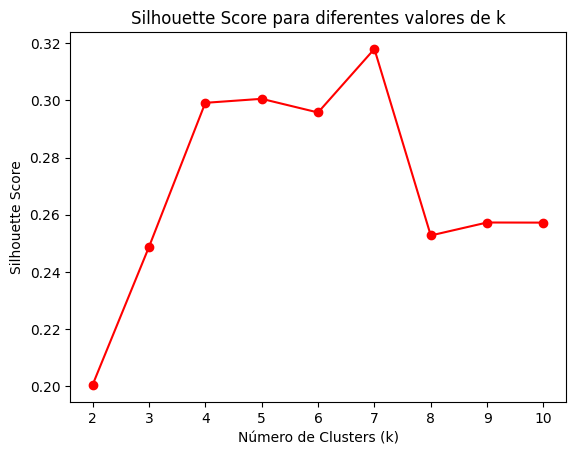

In [97]:
# Gera o gráfico do Silhouette Score
plt.plot(k_values, silhouette_scores, marker='o', color='red')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score para diferentes valores de k')
plt.show()

In [98]:
# 4. Aplica o K-Means com o número ótimo de clusters
# Assumindo que o número ótimo de clusters é 5
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(housing_scaled_df)  # Obtém os clusters

# Adiciona a atribuição de clusters ao DataFrame original
housing_df['cluster'] = clusters
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,house_value_range,Proximity_Level_1O,Proximity_Level_B,Proximity_Level_IN,Proximity_Level_IS,Proximity_Level_NO,cluster
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,350000,False,True,False,False,False,2
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,350000,False,True,False,False,False,2
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,350000,False,True,False,False,False,2
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,350000,False,True,False,False,False,2
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,350000,False,True,False,False,False,2


## O que foi feito:

- A variável cluster foi adicionada ao DataFrame **cali_df** e indica a qual  cluster cada casa foi atribuída, com base nas características de cada casa.
Os valores possíveis na coluna cluster representam os diferentes grupos identificados pelo algoritmo K-Means.

In [99]:
# Mapeia os clusters para os valores das categorias 'Proximity_Level_*'
cluster_map = {
    0: 'Proximity_Level_B',
    1: 'Proximity_Level_IN',
    2: 'Proximity_Level_IS',
    3: 'Proximity_Level_NO',
    4: 'Proximity_Level_1O'
}

# Cria nomes dos clusters baseados no mapeamento
cluster_names = [cluster_map[cluster_id] for cluster_id in clusters]

# Prepara os valores reais (true labels) das classes categóricas
true_labels = housing_df[proximity_columns].idxmax(axis=1)  # Determina a categoria com valor True para cada linha
print(metrics.confusion_matrix(true_labels, cluster_names))

[[   0 8401   83    0  601]
 [   0    0    0 2206   75]
 [   0  172 5866    1  509]
 [   0    5    0    0    0]
 [2562    0    0    0   75]]


In [100]:
def analyze_clusters(housing_df, clusters):

    # Adiciona a coluna de clusters ao DataFrame original
    housing_df['cluster'] = clusters

    # Agrupa por cluster e categorias de proximidade
    cluster_proximity_counts = housing_df.groupby(['cluster'])[proximity_columns].sum()

    # Cria um DataFrame para guardar as métricas
    cluster_stats = pd.DataFrame()
    cluster_stats['cluster'] = cluster_proximity_counts.index
    cluster_stats['total_records'] = cluster_proximity_counts.sum(axis=1)

    # Adiciona contagem por categoria de proximidade
    for category in proximity_columns:
        cluster_stats[f'{category}_count'] = cluster_proximity_counts[category]

    # Calcula proporções de cada categoria em relação ao total de registos do cluster
    for category in proximity_columns:
        cluster_stats[f'{category}_proportion'] = (
            cluster_proximity_counts[category] / cluster_stats['total_records']
        )

    return cluster_stats

cluster_analysis = analyze_clusters(housing_df, clusters)
print(cluster_analysis)

   cluster  total_records  Proximity_Level_1O_count  Proximity_Level_B_count  \
0        0           8578                      8401                        0   
1        1           5949                        83                        0   
2        2           2207                         0                     2206   
3        3           1260                       601                       75   
4        4           2562                         0                        0   

   Proximity_Level_IN_count  Proximity_Level_IS_count  \
0                       172                         5   
1                      5866                         0   
2                         1                         0   
3                       509                         0   
4                         0                         0   

   Proximity_Level_NO_count  Proximity_Level_1O_proportion  \
0                         0                       0.979366   
1                         0                       0.

In [101]:
# Agrupa os dados por cluster e calcula a média das variáveis numéricas
numeric_columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                   'total_bedrooms', 'population', 'households', 'median_income',
                   'median_house_value', 'house_value_range']

# Calcula as médias por cluster
cluster_averages = housing_df.groupby('cluster')[numeric_columns].mean()

# Mostra os resultados
print("Médias das Variáveis Numéricas por Cluster:")
print(cluster_averages)


Médias das Variáveis Numéricas por Cluster:
          longitude   latitude  housing_median_age  total_rooms  \
cluster                                                           
0       -118.783397  34.501190           30.294241  2227.780019   
1       -119.907559  36.929370           25.036813  2181.697596   
2       -122.261912  37.800530           38.370639  2253.036248   
3       -119.096175  35.253111           15.444444  8391.938095   
4       -119.342939  34.748872           29.788447  2332.214676   

         total_bedrooms   population   households  median_income  \
cluster                                                            
0            460.321287  1309.972138   439.016787       4.264019   
1            437.233821  1148.552530   393.075979       3.057527   
2            466.740825  1116.246488   443.020843       4.147889   
3           1681.784127  4310.307937  1539.773810       4.030142   
4            491.313037  1235.136222   458.568696       3.960914   

         

### Explicação:

`groupby('cluster')`: Agrupa os dados com base nos clusters criados anteriormente.

`[['total_rooms', 'median_income', 'households', 'population', 'housing_median_age']]`: Aqui, estamos a selecionar as variáveis relevantes que queremos analisar.

`mean()`: Calcula a média das variáveis selecionadas para cada cluster.

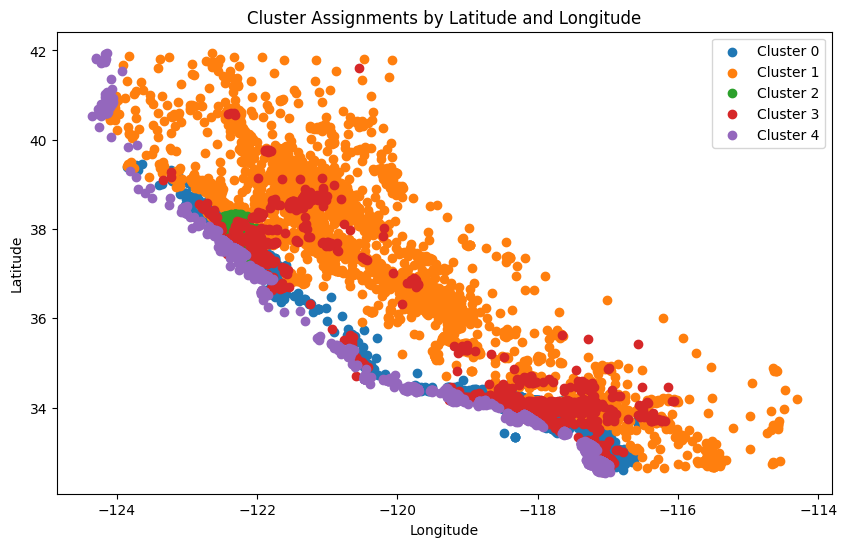

In [102]:
# Visualiza os clusters com base em latitude e longitude
plt.figure(figsize=(10, 6))

# Gera cada cluster separadamente
for cluster_id in range(optimal_k):
    cluster_data = housing_df[housing_df['cluster'] == cluster_id]
    plt.scatter(cluster_data['longitude'], cluster_data['latitude'], label=f'Cluster {cluster_id}')

# Personaliza o gráfico
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cluster Assignments by Latitude and Longitude')
plt.legend()
plt.show()

# Resumo do Gráfico: Cluster Assignments by Latitude and Longitude

## **Objetivo do Gráfico**
O gráfico mostra os clusters formados com base nas **coordenadas geográficas** (latitude e longitude) das casas na Califórnia, utilizando o atributo **`Proximity_Level`** para definir as categorias de proximidade.

---

## **Clusters e Áreas Representadas**
### Cluster 0 (Azul)
- **Categoria:** `<1H OCEAN`
- **Descrição:** Representa casas muito próximas ao oceano, principalmente ao longo da costa norte da Califórnia.

### Cluster 1 (Laranja)
- **Categoria:** `INLAND`
- **Descrição:** Abrange áreas interiores da Califórnia, longe do oceano, como o **Sacramento Valley** e o **San Joaquin Valley**.

### Cluster 2 (Verde)
- **Categoria:** `ISLAND`
- **Descrição:** Representa um número muito pequeno de registros em ilhas ou regiões isoladas (5 registros no total).

### Cluster 3 (Vermelho)
- **Categoria:** `NEAR OCEAN`
- **Descrição:** Corresponde a casas próximas ao oceano, mas não diretamente costeiras, como em áreas urbanizadas costeiras.

### Cluster 4 (Roxo)
- **Categoria:** `NEAR BAY`
- **Descrição:** Representa imóveis próximos a baías, como a **Baía de São Francisco** e outras áreas semelhantes.




## Clustering SEM Proximity_Level attribute

### Lê o ficheiro e prepara os dados

In [104]:
# Remove o atributo 'Proximity_Level_*' para o clustering sem proximidade
housing_without_proximity = housing_df.drop(columns=['Proximity_Level_1O', 'Proximity_Level_B', 'Proximity_Level_IN', 'Proximity_Level_IS', 'Proximity_Level_NO', 'cluster'])

# Mostra as primeiras linhas do DataFrame atualizado
print(housing_without_proximity.head())

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value  \
0       322.0       126.0         8.3252            452600.0   
1      2401.0      1138.0         8.3014            358500.0   
2       496.0       177.0         7.2574            352100.0   
3       558.0       219.0         5.6431            341300.0   
4       565.0       259.0         3.8462            342200.0   

   house_value_range  
0             350000  
1             350000  
2             350000  
3             350000  
4             350000  


In [105]:
# Seleciona todas as features restantes após a remoção de 'Proximity_Level_*'
housing_feature_names = housing_without_proximity.columns.values.tolist()

# Padroniza as features
scaler = StandardScaler()
housing_scaled = scaler.fit_transform(housing_without_proximity)
housing_scaled = pd.DataFrame(housing_scaled, columns=housing_feature_names)

# Mostra as primeiras linhas do DataFrame padronizado
housing_scaled.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,house_value_range
0,-1.326470,1.050390,0.979997,-0.813014,-0.977891,-0.977099,-0.983019,2.392454,2.161934,1.247412
1,-1.321481,1.041032,-0.609175,2.112974,1.386595,0.877986,1.705235,2.379730,1.337936,1.247412
2,-1.331459,1.036353,1.854042,-0.536836,-0.830262,-0.821840,-0.847544,1.821570,1.281893,1.247412
3,-1.336448,1.036353,1.854042,-0.627640,-0.721355,-0.766517,-0.735976,0.958508,1.187322,1.247412
4,-1.336448,1.036353,1.854042,-0.461557,-0.612449,-0.760271,-0.629721,-0.002178,1.195203,1.247412


### K hyperparameter tuning

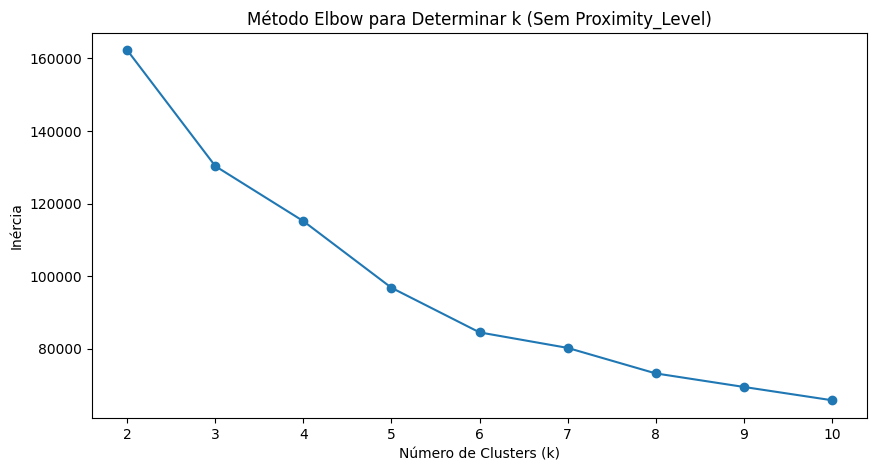

In [107]:
# Testa valores de k de 2 a 10
inertia = []
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=1234)
    kmeans.fit(housing_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(metrics.silhouette_score(housing_scaled, kmeans.labels_))

# Método Elbow
plt.figure(figsize=(10, 5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método Elbow para Determinar k (Sem Proximity_Level)')
plt.show()

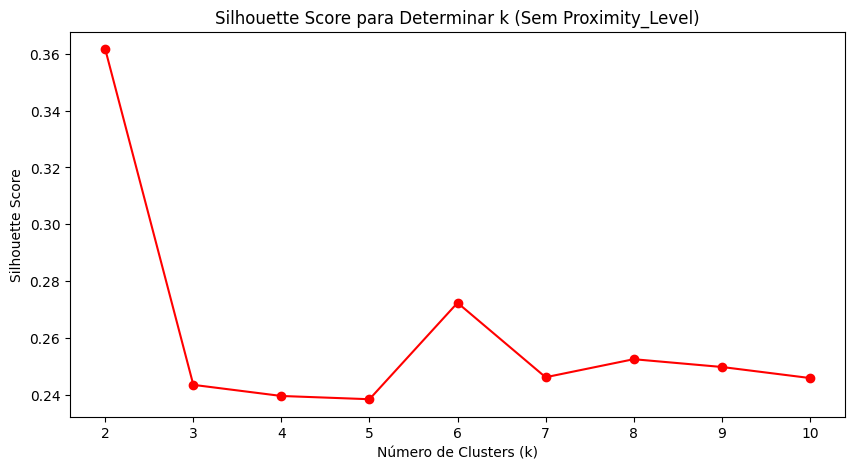

In [108]:
# Silhouette Score
plt.figure(figsize=(10, 5))
plt.plot(k_values, silhouette_scores, marker='o', color='red')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score para Determinar k (Sem Proximity_Level)')
plt.show()

### Aplica o Modelo

In [111]:
# Escolhe o número ideal de clusters com base nos gráficos
optimal_k = 4

# Aplica o K-Means com o número ideal de clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(housing_scaled)

# Adiciona a atribuição de clusters ao DataFrame original
housing_df['cluster'] = clusters

# Mostra as primeiras linhas do DataFrame com os clusters atribuídos
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,house_value_range,Proximity_Level_1O,Proximity_Level_B,Proximity_Level_IN,Proximity_Level_IS,Proximity_Level_NO,cluster
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,350000,False,True,False,False,False,3
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,350000,False,True,False,False,False,1
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,350000,False,True,False,False,False,3
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,350000,False,True,False,False,False,3
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,350000,False,True,False,False,False,3


In [112]:
# Função para contar registos por cluster e calcular métricas
def analyze_clusters(housing, clusters):

    # Agrupa os dados por cluster e calcula contagens de categorias originais
    cluster_species_counts = housing.groupby(['cluster', 'house_value_range']).size().unstack(fill_value=0)
    cluster_stats = pd.DataFrame()
    cluster_stats['cluster'] = cluster_species_counts.index
    cluster_stats['total_houses'] = cluster_species_counts.sum(axis=1)

    # Adiciona as contagens para cada faixa de valor de casa
    for value_range in housing['house_value_range'].unique():
        cluster_stats[f'{value_range}_count'] = cluster_species_counts[value_range]

    # Retorna as estatísticas calculadas
    return cluster_stats

# Exemplo de uso com o DataFrame e clusters gerados
cluster_analysis = analyze_clusters(housing_df, clusters)
print(cluster_analysis)

   cluster  total_houses  350000_count  150000_count  75000_count  \
0        0          6191           166          4678         1257   
1        1          1499           690           700          103   
2        2          5179            77          2900         2088   
3        3          7687          6796           891            0   

   40000_count  22500_count  7500_count  
0           80            8           2  
1            4            2           0  
2          110            2           2  
3            0            0           0  


In [113]:
# Agrupa os dados por cluster e calcula a média das variáveis numéricas
cluster_averages = housing_df.groupby('cluster')[['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
'households', 'median_income', 'median_house_value']].mean()

# Mostra as médias por cluster
print(cluster_averages)

          longitude   latitude  housing_median_age  total_rooms  \
cluster                                                           
0       -117.861930  33.914326           29.476983  1991.485059   
1       -119.169393  35.275530           16.336224  7886.831888   
2       -121.415016  38.134350           27.738946  2028.488511   
3       -119.783710  35.407301           31.043320  2465.598543   

         total_bedrooms   population   households  median_income  \
cluster                                                            
0            453.563075  1355.667743   421.338556       2.986048   
1           1594.776518  4085.329553  1464.165444       4.002109   
2            422.040741  1088.954431   386.363584       2.895202   
3            464.849876  1167.178353   441.360999       5.160164   

         median_house_value  
cluster                      
0             139306.638831  
1             208248.908606  
2             117130.140761  
3             318371.182256  


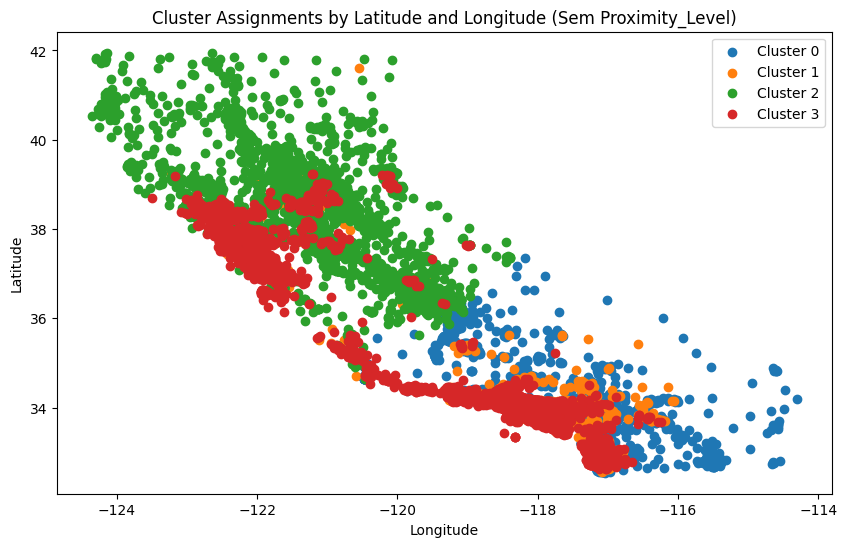

In [114]:
# Visualiza as atribuições de clusters
plt.figure(figsize=(10, 6))

# Loop para gerar os pontos de cada cluster
for cluster_id in range(optimal_k):
    cluster_data = housing_df[housing_df['cluster'] == cluster_id]
    plt.scatter(cluster_data['longitude'], cluster_data['latitude'], label=f'Cluster {cluster_id}')

# Configurações do gráfico
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cluster Assignments by Latitude and Longitude (Sem Proximity_Level)')
plt.legend()
plt.show()

# Resumo do Gráfico: Cluster Assignments by Latitude and Longitude (Sem Proximity_Level)

## **Objetivo do Gráfico**
Representar os clusters formados com base em variáveis numéricas (longitude, latitude, renda, etc.), excluindo os atributos categóricos de `Proximity_Level`, e relacionar com as faixas de preço mapeadas:

- **`0-15000`:** 7500
- **`15000-30000`:** 22500
- **`30000-50000`:** 40000
- **`50000-100000`:** 75000
- **`100000-200000`:** 150000
- **`200000-500000`:** 350000

---

## **Análise dos Clusters**

### **Cluster 0 (Azul):**
- **Regiões:** Sul da Califórnia e áreas costeiras menores.
- **Faixa de preço predominante**: **350000 `(200000-500000)`.
- **Características:** Áreas urbanas e altamente valorizadas.

### **Cluster 1 (Laranja):**
- **Regiões:** Disperso em áreas menores, sem concentração clara.
- **Faixa de preço predominante:** Mistura entre **150000** `(100000-200000)` e **350000** `(200000-500000)`.
- **Características:** Imóveis em regiões específicas, possivelmente de média-alta valorização.

### **Cluster 2 (Verde):**
- **Regiões:** Abrange grande parte das áreas interiores da Califórnia.
- **Faixa de preço predominante**: **75000** `(50000-100000)` e **150000** `(100000-200000)`.
- **Características:** Áreas menos valorizadas e menos densamente povoadas.

### **Cluster 3 (Vermelho):**
- **Regiões:** Amplamente distribuído pelo centro e sul da Califórnia.
- **Faixa de preço predominante**: Mistura entre **150000** `(100000-200000)` e **350000** `(200000-500000)`.
- **Características:** Áreas com preços medianos a altos.

---

## **Diferenças com Clustering com `Proximity_Level`**
- Sem o atributo **`Proximity_Level`**, os clusters refletem apenas padrões baseados em variáveis numéricas.
- Os agrupamentos são menos influenciados por categorias geográficas explícitas (ex.: `NEAR OCEAN` ou `INLAND`).
- Clusters mais gerais, dependentes de variáveis como latitude, longitude, renda, etc.


## Conclusão dos Resultados

O objetivo do projeto foi identificar padrões de agrupamento nas características de imóveis da Califórnia, utilizando o algoritmo de clustering **K-Means**, tanto com quanto sem o atributo categórico `Proximity_Level`.

Esses clusters permitem compreender a relação entre as variáveis numéricas e geográficas com as faixas de preços `(house_value_range)`, facilitando a análise e tomada de decisões para alocação de recursos ou estratégias de mercado.






